<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Modelo_Diagnostico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Inspirado por:
# TFRecord Experiments - Upsample and Coarse Dropout
# https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout/notebook
# Splitting TensorFlow Dataset for Validation
# https://www.kaggle.com/code/tt195361/splitting-tensorflow-dataset-for-validation/notebook
# Rotation Augmentation GPU/TPU - [0.96+]
# https://www.kaggle.com/code/cdeotte/rotation-augmentation-gpu-tpu-0-96/notebook

In [2]:
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [3]:
#!pip install -q tensorflow=="2.10"


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn.model_selection import train_test_split

import efficientnet.tfkeras as efn
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import math
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

In [5]:
print(tf.__version__)
print(tf.keras.__version__)

2.9.2
2.9.0


In [6]:
AUTO = tf.data.experimental.AUTOTUNE
# Ruta a ficheros de TFRecords en GCS
GCS_PATHS = {
  "256x256": "gs://kds-ba3e7d448bf7bdcc890f1dbcce1a34e87acee697ceaaba697d9b5975",
  "384x384": "gs://kds-751ba037a14a150dd732a237b636cac654652a12d9adfeeed3e9441d",
  "512x512": "gs://kds-9f453d1bb81796153f51085b3bb2eb73b2ca03501bdfc5a15011e3fc",
  "768x768":  "gs://kds-96f5a566c923ab0c389beffbe7a714e300c09d8e3bb680ffdfaef6fc"
}


RESOLUTIONS = {
  "256x256": [256, 256],
  "384x384": [384, 384],
  "512x512": [512, 512],
  "768x768": [768, 768]
}

IMAGE_SIZE = RESOLUTIONS["256x256"]

MY_DPI = 96



In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image
    
def read_labeled_tfrecord_with_file_name(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "patient_id": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
        "diagnosis": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image_name = example['image_name']
    target = tf.cast(example['target'], tf.int32)
    return image, image_name, target

def filter_images(image, image_name, target):
  #return tf.strings.regex_full_match(image_name,"^(.*_downsampled)")
  return not tf.strings.regex_full_match(image_name,"^((.*_downsampled))")


  
  #return True

In [8]:
def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord_with_file_name, num_parallel_calls=AUTO).filter(filter_images)
    # returns a dataset of (image, image_target) pairs if labeled=True or
    # (image, image_name) pairs if labeled=False
    return dataset

def print_target_counts(y, label):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    y_0_count = y_counts[0]
    y_1_count = y_counts[1]
    y_1_percent = y_1_count / y_total * 100.0
    print("{0:10s}: Total={1:5d}, 0={2:5d}, 1={3:3d}, ratio of Melanoma={4:.2f}%".format(
        label, y_total, y_0_count, y_1_count, y_1_percent))

def get_selected_dataset(ds, X_indices_np):
    # Make a tensor of type tf.int64 to match the one by Dataset.enumerate(). 
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    
    def is_index_in(index, rest):
        # Returns True if the specified index value is included in X_indices_ts.
        #
        # '==' compares the specified index value with each values in X_indices_ts.
        # The result is a boolean tensor, looks like [ False, True, ..., False ].
        # reduce_any() returns Ture if True is included in the specified tensor.
        return tf.math.reduce_any(index == X_indices_ts)
    
    def drop_index(index, rest):
        return rest

    # Dataset.enumerate() is similter to Python's enumerate().
    # The method adds indices to each elements. Then, the elements are filtered
    # by using the specified indices. Finally unnecessary indices are dropped.
    selected_ds = ds \
        .enumerate() \
        .filter(is_index_in) \
        .map(drop_index)
    return selected_ds

def remove_file_name(image, file, target):
    return image, target

def get_dataset(ds_input, augment = False, shuffle = False, repeat = False, batch_size=16, dim=256):
    ds = ds_input
    ds.cache()
    ds = ds.map(remove_file_name)

    if repeat:
      ds = ds.repeat()

    if shuffle: 
      ds = ds.shuffle(1024*2) #if too large causes OOM in GPU CPU
      opt = tf.data.Options()
      opt.experimental_deterministic = False
      ds = ds.with_options(opt)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)

    return ds


def make_model_check_point(best_model_file_path):
    return ModelCheckpoint(
        best_model_file_path, monitor='val_recall', mode='max',
        verbose=1, save_best_only=True, save_weights_only=False, period=1)


def data_augment(image, target):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image  = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, target


def show_sample_images(thumb_size, ds):
  for img, file, target in iter(ds):
    plt.figure(figsize=(thumb_size/MY_DPI, thumb_size/MY_DPI), dpi=MY_DPI)
    file_name = file.numpy().decode('ascii')
    target_diag = "Melanoma" if target.numpy() else "No melanoma"
    image = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
    image = PIL.Image.fromarray(image)
    print("File: {} Size: {} Diag: {}".format(file_name, image.size,target_diag))
    plt.imshow(image)
    plt.show()
    print("\n")

def display_training_curve(training, validation, title, subplot, ylim):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_ylim(*ylim)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [9]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("REPLICAS: ", strategy.num_replicas_in_sync)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

Running on TPU  grpc://10.72.35.82:8470


REPLICAS:  8


In [10]:
# Get TFRecords 
dataset_files = {}
for resolution, path in GCS_PATHS.items():
    print("Resolution: {}, path: {}".format(resolution, path))
    dataset_files[resolution] = tf.io.gfile.glob(path + '/train*.tfrec')
    print("TFRecord files: ({})".format(len(dataset_files[resolution])))


Resolution: 256x256, path: gs://kds-ba3e7d448bf7bdcc890f1dbcce1a34e87acee697ceaaba697d9b5975
TFRecord files: (30)
Resolution: 384x384, path: gs://kds-751ba037a14a150dd732a237b636cac654652a12d9adfeeed3e9441d
TFRecord files: (30)
Resolution: 512x512, path: gs://kds-9f453d1bb81796153f51085b3bb2eb73b2ca03501bdfc5a15011e3fc
TFRecord files: (30)
Resolution: 768x768, path: gs://kds-96f5a566c923ab0c389beffbe7a714e300c09d8e3bb680ffdfaef6fc
TFRecord files: (30)


In [11]:
# Get datasets

full_datasets = {}
for resolution, files in dataset_files.items():
  IMAGE_SIZE = RESOLUTIONS[resolution]
  full_datasets[resolution] = load_dataset(files, ordered=True)
  print(resolution, full_datasets[resolution])


256x256 <FilterDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
384x384 <FilterDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
512x512 <FilterDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
768x768 <FilterDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


File: ISIC_0000002 Size: (256, 256) Diag: Melanoma


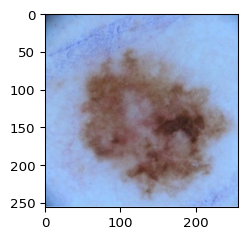



File: ISIC_0053467 Size: (256, 256) Diag: No melanoma


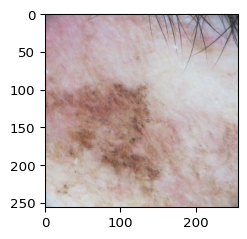

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


File: ISIC_0000002 Size: (512, 512) Diag: Melanoma


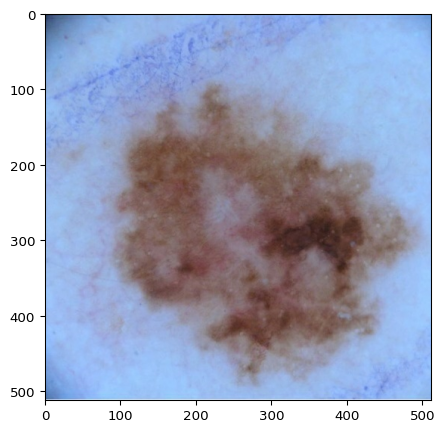



File: ISIC_0053467 Size: (512, 512) Diag: No melanoma


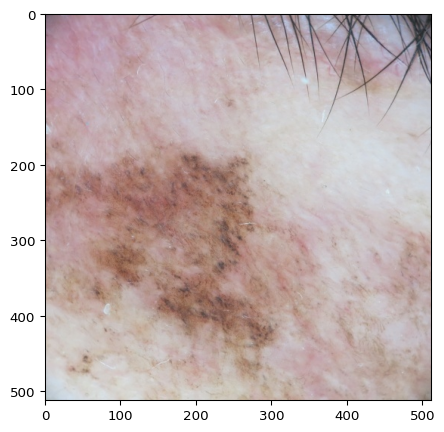

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [12]:
# Show samples
examples = full_datasets['256x256'].take(2)
show_sample_images(256, examples)
examples = full_datasets['512x512'].take(2)
show_sample_images(512, examples)


In [13]:
import PIL
def filter_images_melanoma(image, image_name, target):
  return target == 1

def filter_images_no_melanoma(image, image_name, target):
  return target == 0

def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target = data[0], data[1]
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))
        if idx > cols*rows: break
    display(mosaic)



Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


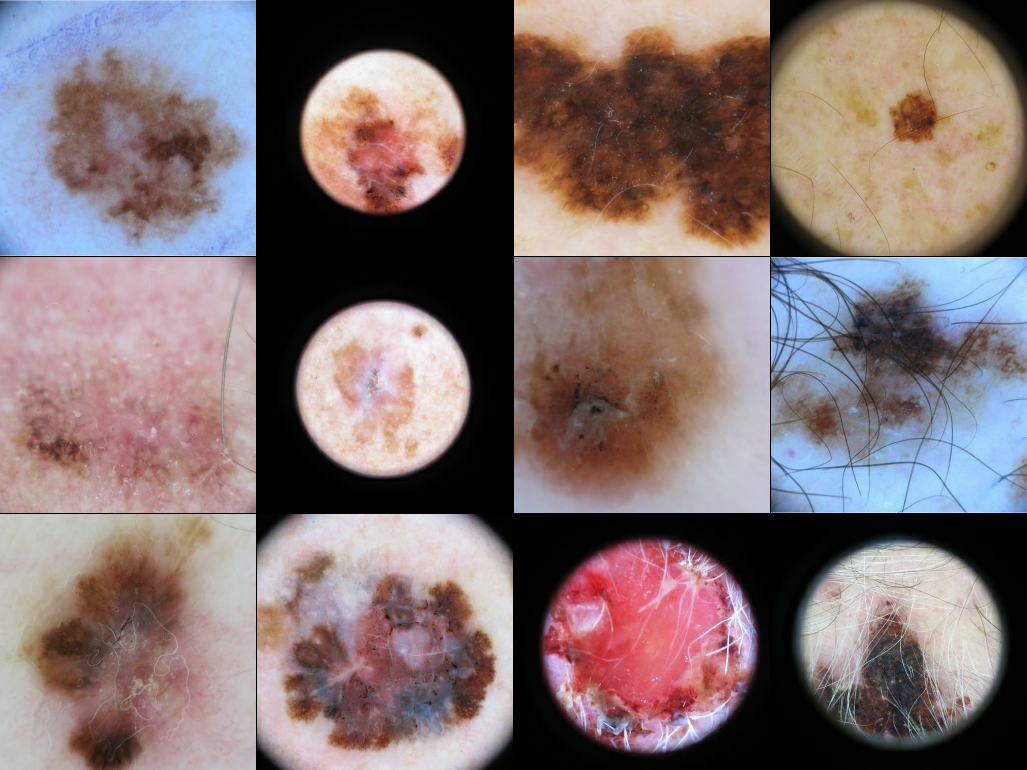

In [14]:
ds = full_datasets["256x256"].filter(filter_images_melanoma).take(4*3) # augment = False
show_dataset(256, 4, 3, ds)

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


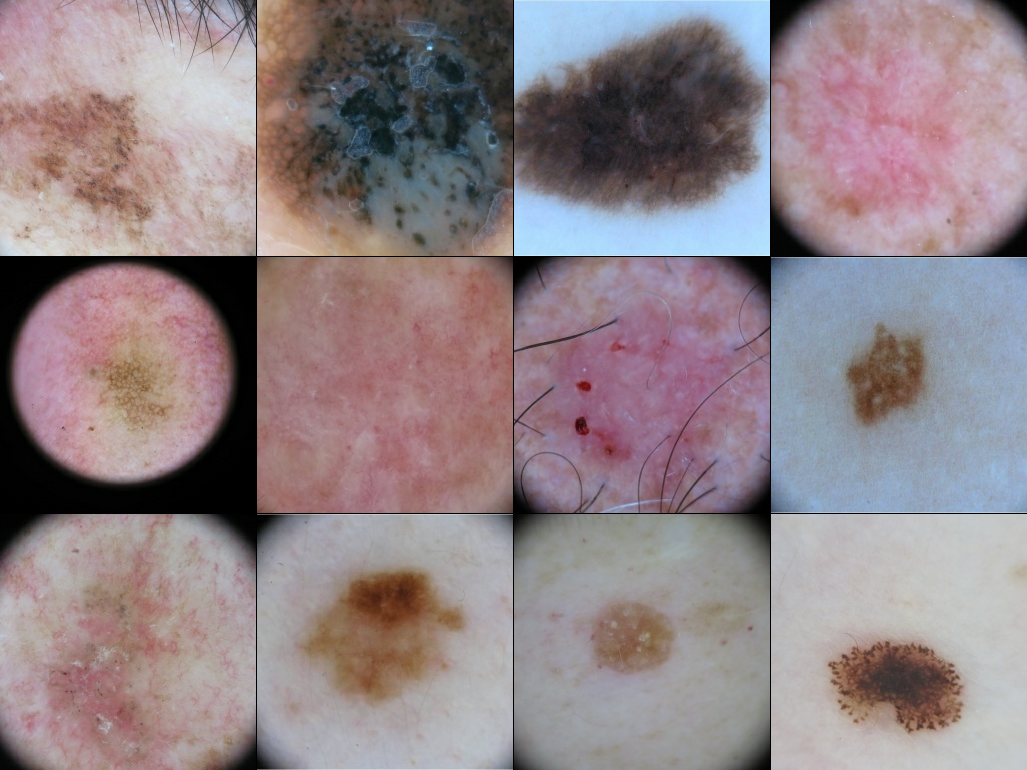

In [15]:
ds = full_datasets["256x256"].filter(filter_images_no_melanoma).take(4*3) # augment = False
show_dataset(256, 4, 3, ds)

In [16]:
# Extract target values from the first dataset.
# Indices are generated along with the target values, which are used to filter dataset.
y_targets = np.array([ target.numpy() for img, file, target in iter(full_datasets['256x256']) ])
X_indices = np.arange(len(y_targets))

print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=23218, 0=19076, 1=4142, ratio of Melanoma=17.84%


In [17]:
# Show target distribution
y_targets = np.array([ target.numpy() for img, file, target in iter(full_datasets['512x512']) ])
X_indices = np.arange(len(y_targets))

print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=23218, 0=19076, 1=4142, ratio of Melanoma=17.84%


In [18]:
# Split experiments / test
X_exp_indices, X_test_indices, y_exp_targets, y_test_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

print_target_counts(y_exp_targets, "Experiments")
print_target_counts(y_test_targets, "Test")

Experiments: Total=19735, 0=16214, 1=3521, ratio of Melanoma=17.84%
Test      : Total= 3483, 0= 2862, 1=621, ratio of Melanoma=17.83%


In [19]:
# Create datasets for experiments and test
experiment_datasets = {}
test_datasets = {} 
for resolution, full_dataset in full_datasets.items():
  experiment_datasets[resolution] =  get_selected_dataset(full_dataset, X_exp_indices)
  test_datasets[resolution] =  get_selected_dataset(full_dataset, X_test_indices)

print(experiment_datasets)
print(test_datasets)

{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '512x512': <MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '768x768': <MapDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [20]:
# Show target distribution in experiments dataset
y_targets = np.array([ target.numpy() for img, file, target in iter(experiment_datasets['256x256']) ])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=19735, 0=16214, 1=3521, ratio of Melanoma=17.84%


In [21]:
y_targets = np.array([ target.numpy() for img, file, target in iter(test_datasets['256x256']) ])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total= 3483, 0= 2862, 1=621, ratio of Melanoma=17.83%


In [22]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

import math
from tensorflow.keras.initializers import Constant

_, (y_target_neg_count, y_target_pos_count) = np.unique(y_targets, return_counts=True)
y_target_pos_ratio = y_target_pos_count / y_target_neg_count
dence_initial_bias = math.log(y_target_pos_ratio)
dense_bias_initializer = Constant(dence_initial_bias)

print(y_target_neg_count, y_target_pos_count)
print(y_target_pos_ratio)
print(dence_initial_bias)

2862 621
0.2169811320754717
-1.5279448781829175


In [23]:
# Split experiments: training / test

# Extract target values from the first dataset.
# Indices are generated along with the target values, which are used to filter dataset.
y_targets = np.array([ target.numpy() for img, file, target in iter(experiment_datasets['256x256']) ])
X_indices = np.arange(len(y_targets))

X_train_indices, X_val_indices, y_train_targets, y_val_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)


print_target_counts(y_train_targets, "Training")
print_target_counts(y_val_targets, "Validation")

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Training  : Total=16774, 0=13781, 1=2993, ratio of Melanoma=17.84%
Validation: Total= 2961, 0= 2433, 1=528, ratio of Melanoma=17.83%


In [24]:
# Create datasets for training and validation
training_datasets = {}
validation_datasets = {} 
for resolution, experiment_dataset in experiment_datasets.items():
  training_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_train_indices)
  validation_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_val_indices)

print(training_datasets)
print(validation_datasets)

{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '512x512': <MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '768x768': <MapDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [25]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [26]:
def get_training_dataset(ds, do_augment=False):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    if do_augment:  dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ds):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ds):
    dataset = ds
    #dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [27]:
def display_curves():
  display_training_curve(
      history.history['loss'], history.history['val_loss'],
      'loss', 221, (0.0, 0.5))
  display_training_curve(
      history.history['auc'], history.history['val_auc'],
      'auc', 222, (0.5, 1.0))
  display_training_curve(
      history.history['precision'], history.history['val_precision'],
      'precision', 223, (0.0, 1.0))
  display_training_curve(
      history.history['recall'], history.history['val_recall'],
      'recall', 224, (0.0, 1.0))

In [53]:
def display_curves2(title, history):
  display_training_curve(
      history.history['loss'], history.history['val_loss'],
      title + 'loss', 221, (0.0, 0.6))
  display_training_curve(
      history.history['auc_roc'], history.history['val_auc_roc'],
      title + 'AUC ROC', 222, (0.5, 1.0))
  display_training_curve(
      history.history['auc_pr'], history.history['val_auc_pr'],
      title + 'AUC PR', 222, (0.5, 1.0))
  display_training_curve(
      history.history['precision'], history.history['val_precision'],
      title + 'Precision', 222, (0.5, 1.0))
  display_training_curve(
      history.history['recall'], history.history['val_recall'],
      title + 'Recall', 222, (0.5, 1.0))

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_file_path = "TFG_mejor_modelo.hdf5"

def make_model_check_point(best_model_file_path):
    return ModelCheckpoint(
        best_model_file_path, monitor='val_auc_pr', mode='max',
        verbose=1, save_best_only=True, save_weights_only=False, period=1)

In [67]:
def create_model(lr=0.00005, init_bias=False, epochs=15, dropout=0.2):
  tf.random.set_seed(33)  
  BATCH_SIZE = 16 * strategy.num_replicas_in_sync
  resolution = "384x384"
  IMAGE_SIZE = RESOLUTIONS[resolution]
  K.clear_session()

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  with strategy.scope():
      if init_bias:
          model = Sequential([
            efn.EfficientNetB4(
                include_top=False, weights="noisy-student",  #'noisy-student', #imagenet
                input_shape=(*IMAGE_SIZE, 3), pooling='avg'),
            Dropout(
                dropout, name="dropout"),
            Dense(1, bias_initializer=dense_bias_initializer,
                activation='sigmoid',name='classify')
        ])
      else:
          model = Sequential([
            efn.EfficientNetB4(
                include_top=False, weights='noisy-student',
                input_shape=(*IMAGE_SIZE, 3), pooling='avg'),
            Dropout(
                dropout, name="dropout"),
            Dense(
                1, activation='sigmoid',name='classify')
        ])
      metrics = [ AUC(name='auc_roc', curve='ROC'), 
                 AUC(name='auc_pr', curve='PR'),
                 Precision(name='precision'), Recall(name='recall') ]  

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
  model.summary()

  model_check_point = make_model_check_point(best_model_file_path)
  history = model.fit(
      get_training_dataset(training_datasets[resolution]), steps_per_epoch=STEPS_PER_EPOCH,
      epochs=epochs, validation_data=get_validation_dataset(validation_datasets[resolution]),
      callbacks=[model_check_point],
      verbose=1)
  return history
 

In [68]:
history = create_model(lr=0.00005, init_bias=True, dropout=0.3, epochs=15)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4 (Functional  (None, 1792)             17673816  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 classify (Dense)            (None, 1)                 1793      
                                                                 
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________


Epoch 1/15
131/131 [==============================] - ETA: 0s - loss: 0.3909 - auc_roc: 0.7778 - auc_pr: 0.4994 - precision: 0.6965 - recall: 0.2115
Epoch 1: val_auc_pr improved from -inf to 0.39522, saving model to TFG_mejor_modelo.hdf5
131/131 [==============================] - 254s 1s/step - loss: 0.3909 - auc_roc: 0.7778 - auc_pr: 0.4994 - precision: 0.6965 - recall: 0.2115 - val_loss: 0.5036 - val_auc_roc: 0.6750 - val_auc_pr: 0.3952 - val_precision: 1.0000 - val_recall: 0.0019
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.3210 - auc_roc: 0.8619 - auc_pr: 0.6465 - precision: 0.7156 - recall: 0.4117
Epoch 2: val_auc_pr improved from 0.39522 to 0.64578, saving model to TFG_mejor_modelo.hdf5
131/131 [==============================] - 56s 430ms/step - loss: 0.3210 - auc_roc: 0.8619 - auc_pr: 0.6465 - precision: 0.7156 - recall: 0.4117 - val_loss: 0.4231 - val_auc_roc: 0.8525 - val_auc_pr: 0.6458 - val_precision: 1.0000 - val_recall: 0.1023
Epoch 3/15
131/131 

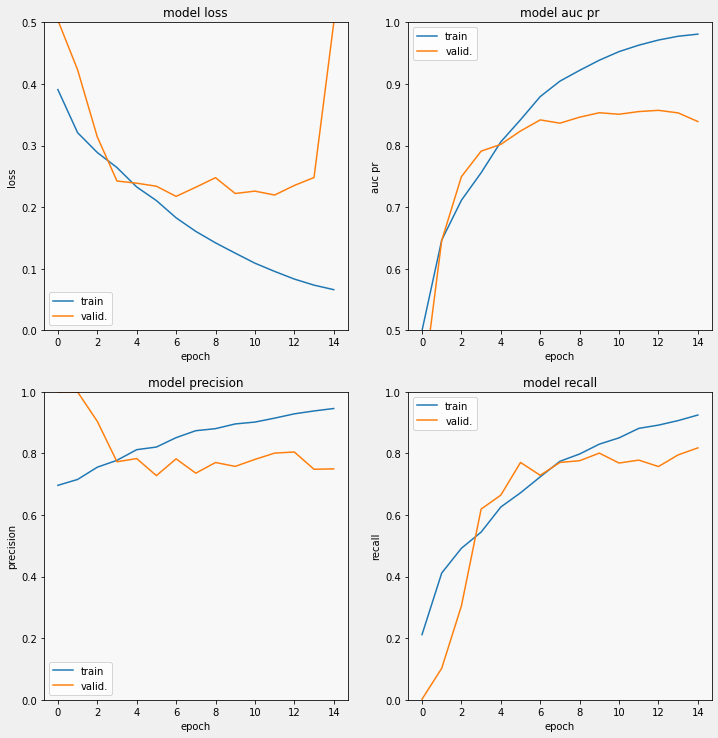

In [69]:
display_training_curve(
    history.history['loss'], history.history['val_loss'],
    'loss', 221, (0.0, 0.5))
display_training_curve(
    history.history['auc_pr'], history.history['val_auc_pr'],
    'auc pr', 222, (0.5, 1.0))
display_training_curve(
    history.history['precision'], history.history['val_precision'],
    'precision', 223, (0.0, 1.0))
display_training_curve(
    history.history['recall'], history.history['val_recall'],
    'recall', 224, (0.0, 1.0))
plt.show()

In [70]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/TFG/TFG_mejor_modelo.hdf5')

In [72]:
resolution = "384x384"
y_true = np.array([
    target.numpy() for img, file_name ,target in iter(get_test_dataset(test_datasets[resolution]).unbatch()) ])
y_pred = model2.predict(get_test_dataset(test_datasets[resolution])).flatten()

print(y_true.shape)
print(y_pred.shape)

Exception ignored in: <function Executor.__del__ at 0x7faa31e02670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


28/28 [==============================] - 105s 4s/step
(3483,)
(3483,)


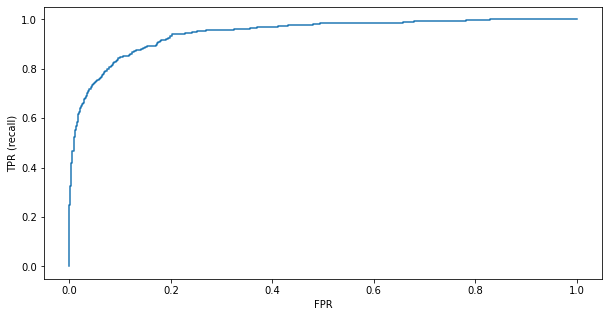

In [73]:

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.show()

In [74]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))

AUC: 0.945


In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Matriz de confusión @{:.2f}'.format(p))
    plt.ylabel('Diagnnóstico real')
    plt.xlabel('Diagnóstico predicho')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])
    #print('Número de imágenes con diagnóstico real de melanoma: ', np.sum(cm[1]))


Verdadero negativo:  2748
Falso positivo:  114
Falso negativo:  175
Vardadero positivo:  446


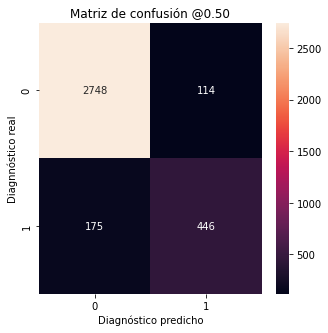

In [82]:
plot_cm(y_true, y_pred, p=0.5)

In [83]:

from sklearn.metrics import precision_recall_fscore_support
y_pred_class = np.where(y_pred > 0.5, 1, 0)
precision_recall_fscore_support(y_true, y_pred_class)

(array([0.94013   , 0.79642857]),
 array([0.96016771, 0.71819646]),
 array([0.95004322, 0.75529213]),
 array([2862,  621]))

ISIC_0053515.png Real: No melanoma  - Predicción:[0.00039608]


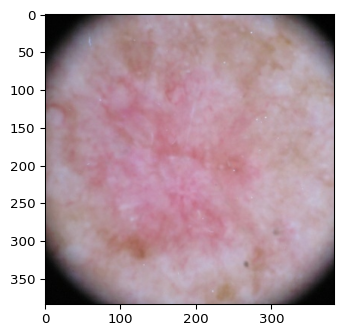

ISIC_0053456.png  Real: Melanoma  - Predicción:[0.99047625]


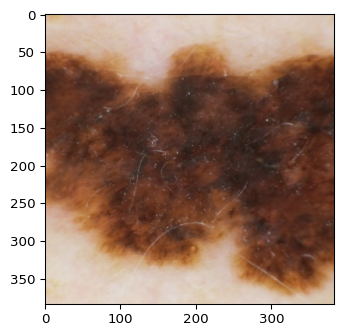

ISIC_0053493.png Real: No melanoma  - Predicción:[0.00146242]


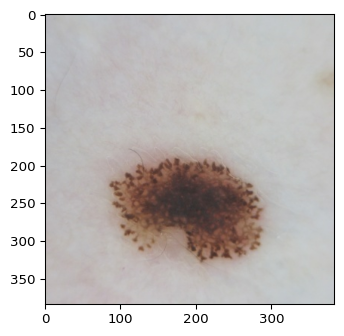

ISIC_0000199.png Real: No melanoma  - Predicción:[0.0467428]


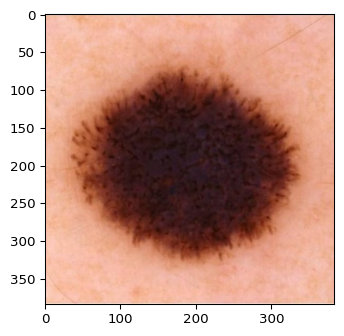

ISIC_0053483.png Real: No melanoma  - Predicción:[0.01241204]


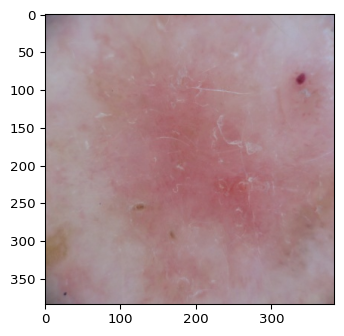

ISIC_0053534.png Real: No melanoma  - Predicción:[0.00309247]


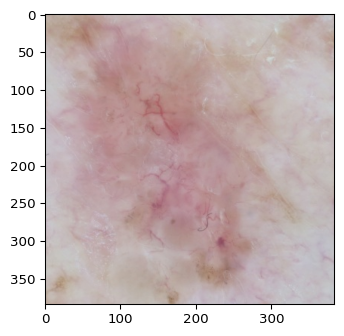

ISIC_0000072.png Real: No melanoma  - Predicción:[0.3139846]


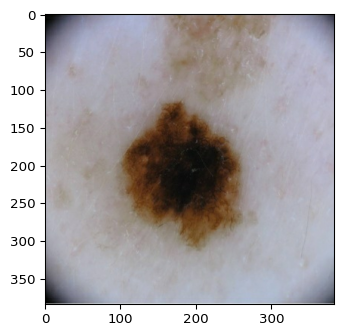

ISIC_0053615.png  Real: Melanoma  - Predicción:[0.9974406]


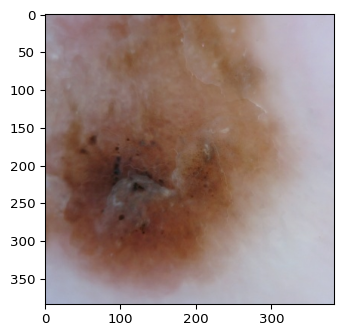

ISIC_0053555.png  Real: Melanoma  - Predicción:[0.99994946]


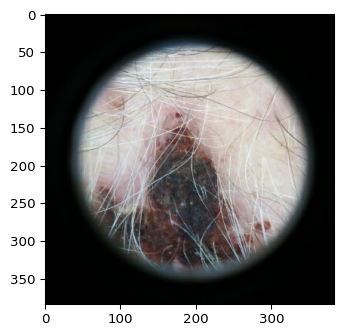

ISIC_0053618.png Real: No melanoma  - Predicción:[0.00029457]


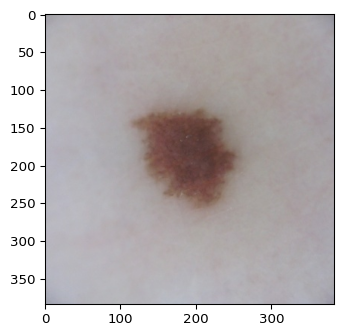

In [89]:
limit = 0
for img, file, target in iter(get_test_dataset(test_datasets[resolution]).unbatch()):
  plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
  file_name = file.numpy().decode('ascii') + '.png'
  target_diag = " Real: Melanoma" if target.numpy() else "Real: No melanoma"
  # target_diag = target.numpy()
  image = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
  image = PIL.Image.fromarray(image)
  tensor = tf.keras.utils.img_to_array(image) / 255
  tensor = tf.expand_dims(tensor,0)
  prediction = " - Predicción:" +  str(model2.predict(tensor, verbose=0).flatten())
  print(file_name, target_diag, prediction)
  plt.imshow(image)
  plt.show()
  image.save("/content/drive/MyDrive/TFG/ISIC/" + file_name)
  limit = limit + 1
  if limit == 10: break

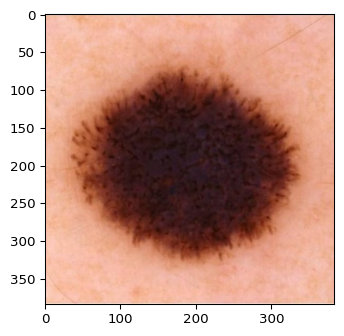

[0.0467428]


In [85]:
plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
image = PIL.Image.open("/content/drive/MyDrive/TFG/ISIC/ISIC_0000199.png")
plt.imshow(image)
plt.show()
tensor = tf.keras.utils.img_to_array(image) / 255
tensor = tf.expand_dims(tensor,0)
prediction = model2.predict(tensor, verbose=0).flatten()
print(prediction)